# StarGAN-v2

### paper 
Choi, Yunjey, et al. "Stargan v2: Diverse image synthesis for multiple domains." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2020.
### code
https://github.com/clovaai/stargan-v2

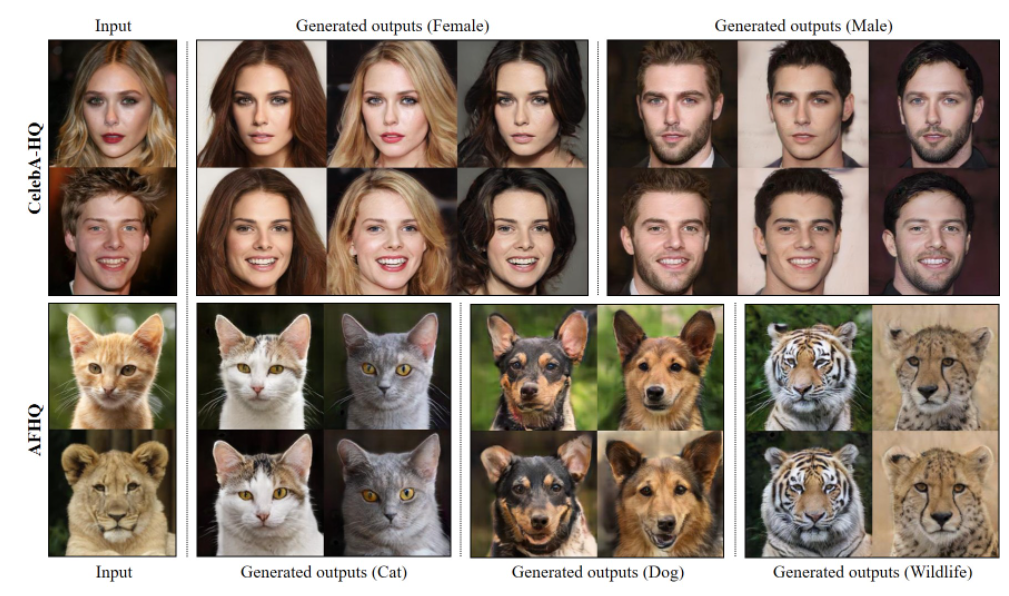

In [ ]:
import os
from munch import Munch # AttrDict 와 같은 역할을 합니다. attribute 형태 혹은 dictionary 형태로 모두 호출할 수 있습니다.
from collections import namedtuple
from copy import deepcopy
from functools import partial
from pathlib import Path
from itertools import chain
import time
import datetime

# math
import math
import random
import numpy as np

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder

# image processing
import cv2
from PIL import Image
from skimage.filters import gaussian
import matplotlib.pyplot as plt

### hyperparameter

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 256
num_domains = 3 # AFHQ dataset (강아지, 고양이, 야생동물)
latent_dim = 16 # latent code의 vector dimension 입니다.
hidden_dim = 512 
style_dim = 64 

# Model

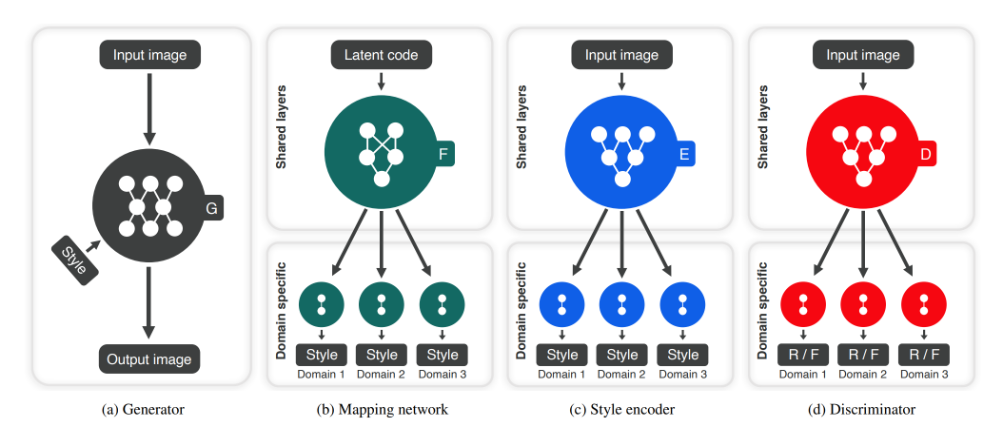

### Generator

In [ ]:
"""
AdaIN (Adaptive Instance Normalization)은 아주 빠른 방식으로 style transfer를 적용할 수 있는 방법론으로,
image feature map 이 각 채널별로 가지는 평균과 분산 값을 조정함으로써 스타일을 바꾸는 방식입니다.
StarGAN-v2 에서는 AdaIN을 이용하여 style을 바꾸는 레이어를 Generator에 추가하였습니다.
"""

class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta

In [ ]:
"""
residual connection 과 convolutional neural network로 이루어진 ResBlk (Residual block) 를 정의합니다.
"""

class ResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, actv=nn.LeakyReLU(0.2),
                 normalize=False, downsample=False):
        super().__init__()
        self.actv = actv
        self.normalize = normalize
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out)

    def _build_weights(self, dim_in, dim_out):
        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        x = self.conv1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self._shortcut(x) + self._residual(x)
        return x / math.sqrt(2)  # unit variance

    


"""
AdainResBlk 은 AdaIN 레이어가 포함된 Residual block 입니다.
"""


class AdainResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=64, actv=nn.LeakyReLU(0.2), upsample=False):
        super().__init__()
        self.actv = actv
        self.upsample = upsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out, style_dim)

    def _build_weights(self, dim_in, dim_out, style_dim=64):
        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.norm2 = AdaIN(style_dim, dim_out)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.learned_sc:
            x = self.conv1x1(x) 
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.actv(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        x = self.norm2(x, s)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x, s):
        out = self._residual(x, s)
        out = (out + self._shortcut(x)) / math.sqrt(2)
        return out


"""
Generator 는 encoder - decoder 구조를 기반으로 만들어져있습니다.
encoder에서는 입력된 이미지의 정보를 추출하고,
decoder에서는 추출된 정보에 style 정보를 입히며 이미지를 생성합니다.
이 때, decoder에서 style을 입히기 위한 방법론으로 AdaIN을 사용합니다.
"""

class Generator(nn.Module):
    def __init__(self, img_size=256, style_dim=64, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        self.img_size = img_size
        self.from_rgb = nn.Conv2d(3, dim_in, 3, 1, 1)
        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()
        self.to_rgb = nn.Sequential(
            nn.InstanceNorm2d(dim_in, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, 3, 1, 1, 0))

        # down/up-sampling blocks
        repeat_num = int(np.log2(img_size)) - 4 # img_size = 256이므로 repeat_num=4 가 됩니다.
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            self.encode.append(
                ResBlk(dim_in, dim_out, normalize=True, downsample=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_in, style_dim, upsample=True))  # stack-like
            dim_in = dim_out
            
            # [1,2,3,4],[5,6,6,5], [4,3,2,1]

        # bottleneck blocks
        for _ in range(2):
            self.encode.append(
                ResBlk(dim_out, dim_out, normalize=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_out, style_dim))


    def forward(self, x, s):
        x = self.from_rgb(x)
        cache = {}
        for block in self.encode:
            x = block(x)
        for block in self.decode:
            x = block(x, s)
        return self.to_rgb(x)

In [ ]:
generator = Generator(img_size, style_dim)

### Mapping network

In [ ]:
"""
Mapping network는 latent code를 입력받아 style을 생성합니다.
"""
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=64, num_domains=2):
        super().__init__()
        layers = []
        layers += [nn.Linear(latent_dim, 512)]
        layers += [nn.ReLU()]
        for _ in range(3):
            layers += [nn.Linear(512, 512)]
            layers += [nn.ReLU()]
        self.shared = nn.Sequential(*layers)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Sequential(nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, style_dim))]

    def forward(self, z, y):
        h = self.shared(z)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim) # y에 입력된 domain 에 해당하는 style 만 추출합니다.
        return s

In [ ]:
mapping_network = MappingNetwork(latent_dim, style_dim, num_domains)

### Style encoder

In [ ]:
"""
StyleEncoder는 입력된 이미지로부터 style을 추출합니다.
"""
class StyleEncoder(nn.Module):
    def __init__(self, img_size=256, style_dim=64, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        self.shared = nn.Sequential(*blocks)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Linear(dim_out, style_dim)]

    def forward(self, x, y):
        h = self.shared(x)
        h = h.view(h.size(0), -1)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s

In [ ]:
style_encoder = StyleEncoder(img_size, style_dim, num_domains)

### Discriminator

In [ ]:
"""
Discriminator는 이미지(x)와 domain 정보(y)를 받아 해당 이미지가 domain 정보를 제대로 담고 있는지, 
real 한 이미지인지 여부를 판단합니다.
"""
class Discriminator(nn.Module):
    def __init__(self, img_size=256, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, num_domains, 1, 1, 0)]
        self.main = nn.Sequential(*blocks)

    def forward(self, x, y):
        out = self.main(x)
        out = out.view(out.size(0), -1)  # (batch, num_domains)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        out = out[idx, y]  # (batch)
        return out

In [ ]:
discriminator =Discriminator(img_size, num_domains)

In [ ]:
"""
Munch 라이브러리를 통해 하나의 network로 구성합니다.
"""
nets = Munch(generator=generator,
             mapping_network=mapping_network,
             style_encoder=style_encoder,
             discriminator=discriminator)

# Dataset

### dataset download

In [ ]:
# !bash download.sh afhq-dataset

### dataloader

In [ ]:
""" 코드 간소화를 위해 폴더의 이미지목록을 추출하는 코드를 만듭니다."""
def listdir(dname):
    fnames = list(chain(*[list(Path(dname).rglob('*.' + ext))
                          for ext in ['png', 'jpg', 'jpeg', 'JPG']]))
    return fnames

"""입력 이미지 (source image) 데이터셋을 구성합니다."""
class DefaultDataset(data.Dataset):
    def __init__(self, root, transform=None):
        self.samples = listdir(root)
        self.samples.sort()
        self.transform = transform
        self.targets = None

    def __getitem__(self, index):
        fname = self.samples[index]
        img = Image.open(fname).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)

"""reference 이미지 데이터셋을 구성합니다."""
class ReferenceDataset(data.Dataset):
    def __init__(self, root, transform=None):
        self.samples, self.targets = self._make_dataset(root)
        self.transform = transform

    def _make_dataset(self, root):
        domains = os.listdir(root)
        fnames, fnames2, labels = [], [], []
        for idx, domain in enumerate(sorted(domains)):
            class_dir = os.path.join(root, domain)
            cls_fnames = listdir(class_dir)
            fnames += cls_fnames
            fnames2 += random.sample(cls_fnames, len(cls_fnames))
            labels += [idx] * len(cls_fnames)
        return list(zip(fnames, fnames2)), labels

    def __getitem__(self, index):
        fname, fname2 = self.samples[index]
        label = self.targets[index]
        img = Image.open(fname).convert('RGB')
        img2 = Image.open(fname2).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            img2 = self.transform(img2)
        return img, img2, label

    def __len__(self):
        return len(self.targets)

""" 데이터가 일부 클래스에 치중되지 않도록 밸런싱을 해주는 sampler를 구성합니다. """
def _make_balanced_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    weights = class_weights[labels]
    return WeightedRandomSampler(weights, len(weights))

""" 
학습용 데이터셋을 구성합니다. 
"""
def get_train_loader(root, which='source', img_size=256,
                     batch_size=8, prob=0.5, num_workers=4):
    print('Preparing DataLoader to fetch %s images '
          'during the training phase...' % which)

    crop = transforms.RandomResizedCrop(
        img_size, scale=[0.8, 1.0], ratio=[0.9, 1.1])
    rand_crop = transforms.Lambda(
        lambda x: crop(x) if random.random() < prob else x) 

    transform = transforms.Compose([
        rand_crop, # 일정 확률로 이미지를 random crop 합니다.
        transforms.Resize([img_size, img_size]),
        transforms.RandomHorizontalFlip(), # 일정 확률로 이미지를 좌우반전시킵니다.
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

    if which == 'source':
        dataset = ImageFolder(root, transform)
    elif which == 'reference':
        dataset = ReferenceDataset(root, transform)
    else:
        raise NotImplementedError

    sampler = _make_balanced_sampler(dataset.targets)
    return data.DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           sampler=sampler,
                           num_workers=num_workers,
                           pin_memory=True, # pin_memory = True 인 경우, cpu에서 gpu로 텐서를 이동시킬 때 유리합니다.
                           drop_last=True) # 마지막 batch의 경우 남는 데이터의 수에 따라 shape가 맞지 않을 수 있으므로 제외합니다.


""" 
평가용 데이터셋을 구성합니다. 
"""
def get_test_loader(root, img_size=256, batch_size=32,
                    shuffle=True, num_workers=4):
    print('Preparing DataLoader for the generation phase...')
    transform = transforms.Compose([
        transforms.Resize([img_size, img_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

    dataset = ImageFolder(root, transform)
    return data.DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=num_workers,
                           pin_memory=True)

"""
데이터로더로부터 나온 결과를 
"""
class InputFetcher:
    def __init__(self, loader, loader_ref=None, latent_dim=16, mode=''):
        self.loader = loader
        self.loader_ref = loader_ref
        self.latent_dim = latent_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.mode = mode

    def _fetch_inputs(self):
        try:
            x, y = next(self.iter)
        except (AttributeError, StopIteration):
            self.iter = iter(self.loader)
            x, y = next(self.iter)
        return x, y

    def _fetch_refs(self):
        try:
            x, x2, y = next(self.iter_ref)
        except (AttributeError, StopIteration):
            self.iter_ref = iter(self.loader_ref)
            x, x2, y = next(self.iter_ref)
        return x, x2, y

    def __next__(self):
        x, y = self._fetch_inputs()
        if self.mode == 'train':
            x_ref, x_ref2, y_ref = self._fetch_refs()
            z_trg = torch.randn(x.size(0), self.latent_dim)
            z_trg2 = torch.randn(x.size(0), self.latent_dim)
            inputs = Munch(x_src=x, y_src=y, y_ref=y_ref,
                           x_ref=x_ref, x_ref2=x_ref2,
                           z_trg=z_trg, z_trg2=z_trg2)
        elif self.mode == 'val':
            x_ref, y_ref = self._fetch_inputs()
            inputs = Munch(x_src=x, y_src=y,
                           x_ref=x_ref, y_ref=y_ref)
        elif self.mode == 'test':
            inputs = Munch(x=x, y=y)
        else:
            raise NotImplementedError

        return Munch({k: v.to(self.device)
                      for k, v in inputs.items()})

데이터와 관련된 hyperparameter 들을 정의합니다.

In [ ]:
train_img_dir = 'data/afhq/train'
val_img_dir = 'data/afhq/val'


randcrop_prob = 0.5
num_workers = 2

batch_size = 1
val_batch_size = 1

In [ ]:
loaders = Munch(src=get_train_loader(root=train_img_dir,
                                             which='source',
                                             img_size=img_size,
                                             batch_size=batch_size,
                                             prob=randcrop_prob,
                                             num_workers=num_workers),
                        ref=get_train_loader(root=train_img_dir,
                                             which='reference',
                                             img_size=img_size,
                                             batch_size=batch_size,
                                             prob=randcrop_prob,
                                             num_workers=num_workers),
                        val=get_test_loader(root=val_img_dir,
                                            img_size=img_size,
                                            batch_size=val_batch_size,
                                            shuffle=True,
                                            num_workers=num_workers))

In [ ]:
fetcher = InputFetcher(loaders.src, loaders.ref, latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, latent_dim, 'val')

### data example

In [ ]:
inputs = next(fetcher)

In [ ]:
inputs.keys()

In [ ]:
for key in inputs.keys():
    print(key, inputs[key].shape)

In [ ]:
inputs_val = next(fetcher_val)

In [ ]:
inputs_val.keys()

In [ ]:
for key in inputs_val.keys():
    print(key, inputs_val[key].shape)

In [ ]:
x_src = inputs.x_src[0].permute(1,2,0).data.cpu().numpy() # 이미지로 보여주기 위해서는 
x_ref = inputs.x_ref[0].permute(1,2,0).data.cpu().numpy() # (3, 256, 256) -> (256, 256, 3)으로 변경시켜주어야합니다.
x_ref2 = inputs.x_ref2[0].permute(1,2,0).data.cpu().numpy()

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.imshow(x_src*0.5+0.5) # -1~1 로 normalize 된 이미지를 0~1로 복구시킵니다.
plt.title('x_src')
plt.subplot(1,3,2)
plt.imshow(x_ref*0.5+0.5)
plt.title('x_ref')
plt.subplot(1,3,3)
plt.imshow(x_ref2*0.5+0.5)
plt.title('x_ref2')
plt.show()

# criterion & optimizer

In [ ]:
"""
각 network 마다 optimizer를 만들어줍니다.
"""
optims = Munch()
for net in nets.keys():
    optims[net] = torch.optim.Adam(params=nets[net].parameters(),
                                    lr=1e-6 if net == 'mapping_network' else 1e-4,
                                    betas=[0.0, 0.99],
                                    weight_decay=1e-4)

In [ ]:
"""
0 또는 1로 구분하도록 하는 adversarial loss를 구성합니다.
"""
def adv_loss(logits, target):
    assert target in [1, 0]
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss

"""
adversarial loss 에 추가적으로 사용되는 gradient penalty를 계산합니다.
여기서는 gradient penalty 중 zero-centered gradient penalty 라는 기법을 사용합니다.
"""
def r1_reg(d_out, x_in):
    batch_size = x_in.size(0)
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

In [ ]:
"""
discriminator는 real image는 1, fake image는 0으로 구분하도록 학습됩니다.
"""
def compute_d_loss(nets, x_real, y_org, y_trg, z_trg=None, x_ref=None):
    assert (z_trg is None) != (x_ref is None)
    # with real images
    x_real.requires_grad_() # x_real 이 gradient가 흐를 수 있도록 바꾸어줍니다.
    out = nets.discriminator(x_real, y_org) # 실제 입력과 실제 입력데이터의 domain 정보를 입력합니다.
    loss_real = adv_loss(out, 1) # 예측 결과값이 1이 되도록 학습합니다.
    loss_reg = r1_reg(out, x_real) # gradient penalty를 적용합니다.

    # with fake images
    with torch.no_grad():
        if z_trg is not None:
            s_trg = nets.mapping_network(z_trg, y_trg) # 입력된 target domian과 latent code 로부터 style을 생성합니다.
        else:  # x_ref is not None
            s_trg = nets.style_encoder(x_ref, y_trg) # 입력된 target domain과 reference image로부터 style을 생성합니다.

        x_fake = nets.generator(x_real, s_trg) # 입력 이미지 (source image)와 style로부터 fake image를 생성합니다.
    out = nets.discriminator(x_fake, y_trg) # fake image와 target domain 을 입력하여 discriminator가 분류하도록 합니다.
    loss_fake = adv_loss(out, 0) # discriminator가 fake image를 볼 때에는 0을 예측하도록 학습합니다.

    loss = loss_real + loss_fake + loss_reg # 최종 loss를 모두 더해줍니다.
    return loss, Munch(real=loss_real.item(),
                       fake=loss_fake.item(),
                       reg=loss_reg.item())

"""
1. generator는 discriminator가 fake image를 1로 예측하도록 학습합니다.
2. generator는 style을 입력받았을 때 적절한 style을 반영하도록 학습합니다 (style reconstruction loss)
3. generator에 입력된 서로 다른 style vector는 서로 다른 이미지를 만들도록 학습됩니다. (diversity sensitive loss)
4. generator에 fake image와 original image의 style을 입력하면 original image를 다시 만들도록 학습합니다. (cycle-consistency loss) 
"""
def compute_g_loss(nets, x_real, y_org, y_trg, z_trgs=None, x_refs=None):
    assert (z_trgs is None) != (x_refs is None)
    if z_trgs is not None:
        z_trg, z_trg2 = z_trgs
    if x_refs is not None:
        x_ref, x_ref2 = x_refs

    # adversarial loss
    if z_trgs is not None:
        s_trg = nets.mapping_network(z_trg, y_trg)
    else:
        s_trg = nets.style_encoder(x_ref, y_trg)

    x_fake = nets.generator(x_real, s_trg)
    out = nets.discriminator(x_fake, y_trg)
    loss_adv = adv_loss(out, 1)

    # style reconstruction loss
    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = torch.mean(torch.abs(s_pred - s_trg))

    # diversity sensitive loss
    if z_trgs is not None:
        s_trg2 = nets.mapping_network(z_trg2, y_trg)
    else:
        s_trg2 = nets.style_encoder(x_ref2, y_trg)
    x_fake2 = nets.generator(x_real, s_trg2)
    x_fake2 = x_fake2.detach()
    loss_ds = torch.mean(torch.abs(x_fake - x_fake2))

    # cycle-consistency loss
    s_org = nets.style_encoder(x_real, y_org)
    x_rec = nets.generator(x_fake, s_org) 
    loss_cyc = torch.mean(torch.abs(x_rec - x_real))

    loss = loss_adv +loss_sty - loss_ds + loss_cyc
    return loss, Munch(adv=loss_adv.item(),
                       sty=loss_sty.item(),
                       ds=loss_ds.item(),
                       cyc=loss_cyc.item())

# Training

In [ ]:
"""
코드 간소화를 위해 예측 결과 이미지를 보여주는 코드를 작성합니다.
"""
def show_image(nets, inputs, latent_dim=16):
    x_src, y_src = inputs.x_src, inputs.y_src
    x_ref, y_ref = inputs.x_ref, inputs.y_ref

    device = inputs.x_src.device
    
    # reference-guided image synthesis & cycle consistency
    N, C, H, W = x_src.size()
    s_ref = nets.style_encoder(x_ref, y_ref)
    x_fake = nets.generator(x_src, s_ref)
    s_src = nets.style_encoder(x_src, y_src)
    x_rec = nets.generator(x_fake, s_src)
    
    plt.figure(figsize=(20,7))
    plt.subplot(1,4,1)
    plt.imshow(x_src.data.cpu()[0].permute(1,2,0)*0.5+0.5)
    plt.title('x_src')
    plt.subplot(1,4,2)
    plt.imshow(x_ref.data.cpu()[0].permute(1,2,0)*0.5+0.5)
    plt.title('x_ref')
    plt.subplot(1,4,3)
    plt.imshow(x_fake.data.cpu()[0].permute(1,2,0).clamp(min=-1,max=1)*0.5+0.5)
    plt.title('x_fake')
    plt.subplot(1,4,4)
    plt.imshow(x_rec.data.cpu()[0].permute(1,2,0).clamp(min=-1,max=1)*0.5+0.5)
    plt.title('x_rec')
    plt.show()
    
    
    # latent-guided image synthesis
    n_out = 3
    
    plt.figure(figsize=(20,15))
    for i in range(3):
        plt.subplot(n_out,4,1+4*i)
        plt.imshow(x_src.data.cpu()[0].permute(1,2,0)*0.5+0.5)
        plt.title('x_src')
    
    y_trg_list = [torch.tensor(y).repeat(N).to(device) for y in range(3)] # num_domains = 3
    z_trg_list = torch.randn(n_out, 1, latent_dim).repeat(1, N, 1).to(device)
    N, C, H, W = x_src.size()
    latent_dim = z_trg_list[0].size(1)

    for i, y_trg in enumerate(y_trg_list):
        n = 0
        z_many = torch.randn(10000, latent_dim).to(x_src.device)
        y_many = torch.LongTensor(10000).to(x_src.device).fill_(y_trg[0])
        s_many = nets.mapping_network(z_many, y_many)
        s_avg = torch.mean(s_many, dim=0, keepdim=True)
        s_avg = s_avg.repeat(N, 1)

        for z_trg in z_trg_list:
            n+=1
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x_src, s_trg)

            plt.subplot(n_out,4,n+i*4+1)
            plt.imshow(x_fake.data.cpu()[0].permute(1,2,0).clamp(min=-1,max=1)*0.5+0.5)
            plt.title('x_fake-{}'.format(n))
    plt.show()
    

In [ ]:
"""
모든 network를 gpu로 옮기고, 학습 모드로 만들어줍니다.
"""
for key in nets.keys():
    nets[key] = nets[key].cuda() #.to(device)
    nets[key].train()

In [ ]:
total_iters = 100000 # 10만회 iteration동안 학습합니다.

In [ ]:
start_time = time.time()
for i in range(total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2


    # train the discriminator
    """
    latent code를 입력한 경우와 reference image를 입력한 경우를 따로 학습합니다.
    """
    d_loss, d_losses_latent = compute_d_loss(
        nets, x_real, y_org, y_trg, z_trg=z_trg)
    for optim in optims.values():
        optim.zero_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, x_real, y_org, y_trg, x_ref=x_ref)
    for optim in optims.values():
        optim.zero_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    """
    discriminator와 마찬가지로, latent code를 입력한 경우와 reference image를 입력한 경우를 따로 학습합니다.
    """
    g_loss, g_losses_latent = compute_g_loss(
        nets, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2])
    for optim in optims.values():
        optim.zero_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()

    g_loss, g_losses_ref = compute_g_loss(
        nets, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2])
    for optim in optims.values():
        optim.zero_grad()
    g_loss.backward()
    optims.generator.step()

    # print out log info
    if (i+1) % 10 == 0:
        #log 
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "[%s], iter [%i/%i], " % (elapsed, i+1, total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)
        
        
    if (i+1) % 100 == 0:
        # result
        show_image(nets, inputs_val)

# Testing with pretrained network

### model download

In [ ]:
# !bash download.sh pretrained-network-afhq

### model load

In [ ]:
ckpt_path = 'expr/checkpoints/afhq/100000_nets_ema.ckpt'

In [ ]:
ckpt = torch.load(ckpt_path)

In [ ]:
ckpt.keys()

In [ ]:
for key in ckpt.keys():
    if key == 'fan':
        continue
    nets[key].load_state_dict(ckpt[key], strict=False)
    
for net in nets.values():
    net.eval()
    net.cuda()

### test

In [ ]:
show_image(nets, inputs_val)

In [ ]:
start_time = time.time()
for i in range(total_iters):
    # fetch images and labels
    inputs = next(fetcher_val)
    show_image(nets, inputs)
    print('\n\n')